In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)



In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate
from src.interpolate import *
from src.emfiles import load_data,crop_fourier_images
import jax

from external.pyem.project import project as project_pyem
from external.pyem.pyem import star
from external.pyem.pyem import vop
import mrcfile

### Read the data

In [3]:
#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
#star_file = "job550_particles_roy40k.star"
#star_file = "job550_particles.star"


#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"


data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
star_file = "Extract/job020/particles.star"

imgs_f, params = load_data(data_dir, star_file)
ctf_params = params["ctf_params"]
pixel_size = params["pixel_size"]
angles = params["angles"]
shifts = params["shifts"]


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:532: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_NAME].str.split("@").str
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:540: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_ORIGINAL_NAME].str.split("@").str


load_data: number of partcles:  5090
load_data: data loaded, time:  6.6160430908203125
load_data: FFT of data, time:  9.58630919456482


(5090, 256, 256)
(5090,)
(5090, 3)
(5090, 2)
(5090, 9)


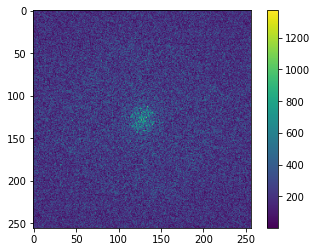

In [4]:
print(imgs_f.shape)
print(pixel_size.shape)
print(angles.shape)
print(shifts.shape)
print(ctf_params.shape)

plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[101]))); plt.colorbar()

In [5]:
nx = 64
N = imgs_f.shape[0]
imgs_f = crop_fourier_images(imgs_f, 64)


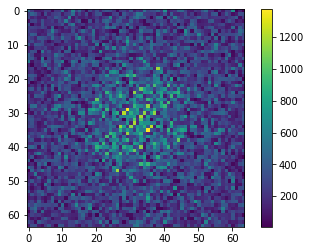

In [6]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[101].reshape(nx,nx)))); plt.colorbar()

### Create the grids

In [7]:
nx0 = 256

# Assume the pixel size is the same for all images
px = pixel_size[0]

x_freq = np.fft.fftfreq(nx0, px)
y_freq = np.fft.fftfreq(nx0, px)
z_freq = np.fft.fftfreq(nx0, px)

# Important thast the grids are not jax (aka Tracer)  objects
#x_grid = np.array([x_freq[1], len(x_freq)])
#y_grid = np.array([y_freq[1], len(y_freq)])
#z_grid = np.array([z_freq[1], len(z_freq)])

x_grid = np.array([x_freq[1], nx])
y_grid = np.array([y_freq[1], nx])
z_grid = np.array([z_freq[1], nx])



#X, Y, Z = jnp.meshgrid(x_freq,z_freq,y_freq)
#mask = create_mask(X, Y, Z , (0,0,0),0.4)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

#print(np.sum(mask[:,:,0]))
print(x_grid)

[3.13873214e-03 6.40000000e+01]


In [8]:
@jax.jit
def slice_func(v, angles, shifts, ctf_params):
    projection, _ = project(v, x_grid, y_grid, z_grid, angles, shifts, "tri", ctf_params)

    return projection

@jax.jit
def slice_func_array(v, angles, shifts, ctf_params):    
    return jax.vmap(slice_func, in_axes = (None, 0, 0, 0))(v, angles)

In [24]:
@jax.jit
def l2sq(x):
    return jnp.real(jnp.sum(jnp.conj(x)*x))

@jax.jit
def loss_func(v, angles, shifts, ctf_params, img, alpha = 0.1):
    #return 1/(2* nx*nx) * l2sq(slice_func(v, angles) - img)
    
    # With l2 regularization
    return 1/(2* nx*nx) * (alpha * l2sq(v) + l2sq(slice_func(v, angles, shifts, ctf_params) - img))
    #return 1/(2* 4096.0) * (alpha * l2sq(v) + l2sq(slice_func(v, angles, shifts, ctf_params) - img))



@jax.jit
def loss_func_batched(v, angles, shifts, ctf_params, imgs):
    return jax.vmap(loss_func, in_axes = (None, 0, 0, 0, 0))(v, angles, shifts, ctf_params, imgs)

@jax.jit
def loss_func_sum(v, angles, shifts, ctf_params, imgs):
    return jnp.mean(loss_func_batched(v, angles, shifts, ctf_params, imgs))

In [25]:
@jax.jit
def grad_loss_volume(v, angles, shifts, ctf_params, img):
    return jax.grad(loss_func)(v, angles, shifts, ctf_params, img)

@jax.jit
def grad_loss_volume_batched(v, angles, shifts, ctf_params, imgs):
    return 1/N * jnp.sum(jax.vmap(grad_loss_volume, in_axes = (None, 0, 0, 0, 0))(v, angles, shifts, ctf_params, imgs), axis=0)

@jax.jit
def grad_loss_volume_sum(v, angles, shifts, ctf_params, imgs):
    return jax.grad(loss_func_sum)(v, angles, shifts, ctf_params, imgs)



Test the functions above with a random volume

In [26]:
vf = jnp.array(np.random.randn(nx,nx,nx))

In [27]:
sf = slice_func(vf, angles[0], shifts[0], ctf_params[0])
sf.shape

(4096,)

In [28]:
start = time.time()
ll = grad_loss_volume(vf, angles[0], shifts[0], ctf_params[0], imgs_f[0])
print(time.time()-start)
print(ll.shape)

1.2261993885040283
(64, 64, 64)


In [29]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(vf, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx])
print(time.time()-start)
print(ll.shape)

1.4461960792541504
(64, 64, 64)


### CG

In [30]:
from src.algorithm import conjugate_gradient

v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
v0 = jnp.zeros([nx,nx,nx])* 1j
N_iter = 50
zero = jnp.zeros(v0.shape).astype(jnp.complex64)

Abfun = grad_loss_volume_sum(zero, angles, shifts, ctf_params, imgs_f)
Ab = - jnp.conj(Abfun)
AA = lambda vv : jnp.conj(grad_loss_volume_sum(vv, angles, shifts, ctf_params, imgs_f)) + Ab

vcg, max_iter = conjugate_gradient(AA, Ab, v0, N_iter, verbose = True)

Iter 0 ||r|| = 0.013968925734352829
Iter 1 ||r|| = 0.0031550257359619343
Iter 2 ||r|| = 0.005591644458291829
Iter 3 ||r|| = 0.004845503215199965
Iter 4 ||r|| = 0.003611400490985356
Iter 5 ||r|| = 0.002151386797581398
Iter 6 ||r|| = 0.000829897932399976
Iter 7 ||r|| = 0.000532544608064193
Iter 8 ||r|| = 0.001480544705417198
Iter 9 ||r|| = 0.0016218733404052478
Iter 10 ||r|| = 0.0017587432559936257
Iter 11 ||r|| = 0.0018823468094309424
Iter 12 ||r|| = 0.001984713375042767
Iter 13 ||r|| = 0.002058513987649056
Iter 14 ||r|| = 0.0020977236472854034
Iter 15 ||r|| = 0.0020984202909878086
Iter 16 ||r|| = 0.002059371815197729
Iter 17 ||r|| = 0.0019822128035432416
Iter 18 ||r|| = 0.0018711348693199684
Iter 19 ||r|| = 0.001732142086078761
Iter 20 ||r|| = 0.0015720304880239772
Iter 21 ||r|| = 0.0013973225908988699
Iter 22 ||r|| = 0.0012134767499524907
Iter 23 ||r|| = 0.0010249878989550191
Iter 24 ||r|| = 0.0008378086128594505
Iter 25 ||r|| = 0.0006659411256549516
Iter 26 ||r|| = 0.0005371651493242

In [31]:
#for i in range(10):
#    vcg, max_iter = conjugate_gradient(AA, Ab, vcg*mask, N_iter, verbose = True)

In [32]:
#print("Final loss function = ", loss_func_sum(vcg, angles, shifts, ctf_params, imgs_f))

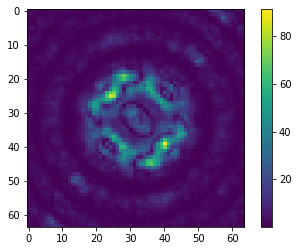

In [33]:
i = 2110
s0 = slice_func(vcg, angles[i], shifts[i], ctf_params[i])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

Text(0.5, 1.0, 'Reconstruction MIP')

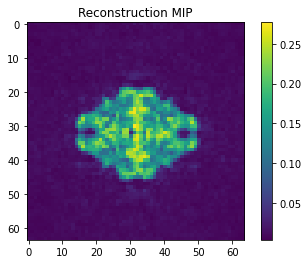

In [34]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg))))
plt.colorbar()
plt.title('Reconstruction MIP')

In [35]:
vr = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg))) 

In [36]:
vr.shape

(64, 64, 64)

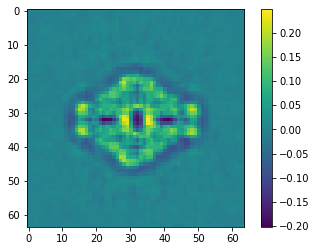

In [37]:
plt.imshow(vr[:,:,32]); plt.colorbar()

### Write volume to file

In [40]:
with mrcfile.new('../data/reconstruction.mrc', overwrite=True) as mrc:
    mrc.set_data(vr.astype(np.float32))